In [1]:
import sys
from pathlib import Path

# プロジェクトルートを設定
PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name in ["notebooks", "src"]:
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

import os
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from numpy.polynomial import Polynomial

# Import modules using legacy aliases expected by later cells
from src import flarepy_EK_Dra as ek_module
from src import flarepy_DS_Tuc_A as ds_module
from src import flarepy_V889_Her as v889_module

# Monkey patch modules to expose FlareDetector class as expected
ek_module.FlareDetector = ek_module.FlareDetector_EK_Dra
ds_module.FlareDetector = ds_module.FlareDetector_DS_Tuc_A
v889_module.FlareDetector = v889_module.FlareDetector_V889_Her

# Also provide direct aliases if used elsewhere
EK_Dra = ek_module
DS_Tuc = ds_module
V889 = v889_module

# Legacy import of single class
from src.flarepy_DS_Tuc_A import FlareDetector_DS_Tuc_A as FlareDetector

# Migrated visualization module
try:
    from src.visualization import (
        plot_flare_frequency,
        plot_total_energy,
        plot_max_energy,
        plot_cumulative_energy,
        STAR_COLORS
    )
    print("Successfully imported src.visualization module")
except ImportError as e:
    print(f"Warning: Could not import src.visualization: {e}")


Successfully imported src.visualization module


In [2]:
# モジュールは Cell 0 でインポート済みのもの (ek_module, ds_module, v889_module) を使用します

# =========================================================
# フォルダ名（実際のディレクトリ名）と、表示名（ラベル）を分けて管理
# folder: os.listdir(BASE_STARS_FOLDER) で出てくる名前と一致させる
# label : 図やログで見せたい名前（スペース入りなど自由）
# =========================================================
STAR_INFO = {
    "EKDra":    {"class": ek_module.FlareDetector,   "label": "EK Dra"},
    "V889 Her": {"class": v889_module.FlareDetector, "label": "V889 Her"},
    "DS Tuc":   {"class": ds_module.FlareDetector,   "label": "DS Tuc"},
    # 他の星も追加するなら同様に:
    # "FolderName": {"class": some_module.FlareDetector, "label": "Nice Label"},
}

# 星のデータが格納されている親フォルダ
# data/TESS/(starname) の形に合わせてパスを設定
# PROJECT_ROOT は Cell 0 で定義済み
BASE_STARS_FOLDER = PROJECT_ROOT / "data" / "TESS"

print(f"Base stars folder set to: {BASE_STARS_FOLDER}")


Base stars folder set to: /Users/daisukeyamashiki/Code/Research/kyoto-flare-detection/data/TESS


In [3]:
print("\n--- DEBUG INFO: Checking Attributes ---")
if 'all_stars_detectors' in locals() and all_stars_detectors:
    try:
        # 辞書から最初の星の名前を取得
        first_star_name = next(iter(all_stars_detectors))
        first_star_detectors = all_stars_detectors[first_star_name]

        if first_star_detectors:
            # その星の最初のインスタンスを取得
            first_instance = next(iter(first_star_detectors.values()))
            print(f"List of attributes for one instance of star '{first_star_name}':")

            # インスタンスが持つ全ての属性名と、その中身（最初の50文字）を表示
            for attr in dir(first_instance):
                if not attr.startswith('__'): # 特殊な属性は無視
                    try:
                        value = getattr(first_instance, attr)
                        print(f"  - {attr}: {str(value)[:50]}") # 値を少しだけ表示
                    except Exception:
                        print(f"  - {attr}: (Could not get value)")

    except StopIteration:
        print("Could not find any stars or detectors to debug.")
    except Exception as e:
        print(f"An error occurred during debugging: {e}")
print("--- END DEBUG INFO ---\n")


--- DEBUG INFO: Checking Attributes ---
--- END DEBUG INFO ---




Error: 'all_stars_detectors' dictionary not found or is empty.


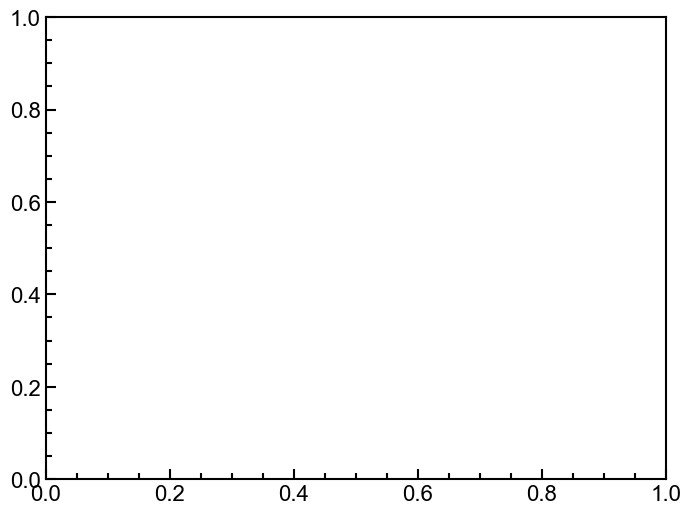

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit

# =========================
# 論文用のスタイル設定
# =========================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# =========================
# 属性名（あなたがクラスに追加したやつ）
# =========================
x_axis_attribute = 'array_starspot'
n_axis_attribute = 'array_flare_number'
t_axis_attribute = 'array_precise_obs_time'
y_axis_attribute = 'array_flare_ratio'   # ★ flare_ratio の配列名（違うならここだけ変えろ）

# =========================
# 表示設定（凡例なし）
# =========================
color_map = {
    'DS Tuc': 'black',
    'EK Dra': (0.8, 0.3, 0.3),
    'V889 Her': (0.3, 0.3, 0.8)
}
marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

MARKER_SIZE = 8
CAPSIZE = 2
ELINEWIDTH = 1.2

def power_law(x, a, b):
    return a * x**b

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

# =========================
# メイン
# =========================
if 'all_stars_detectors' in globals() and all_stars_detectors:

    for star_name, detectors_dict in all_stars_detectors.items():
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'o')
        current_linestyle = linestyle_map.get(star_name, '-')

        x_all, y_all, yerr_all = [], [], []

        for det in detectors_dict.values():
            if not (hasattr(det, x_axis_attribute) and hasattr(det, n_axis_attribute) and hasattr(det, t_axis_attribute)):
                continue

            x_arr = np.asarray(getattr(det, x_axis_attribute), dtype=float)
            N_arr = np.asarray(getattr(det, n_axis_attribute), dtype=float)
            T_arr = np.asarray(getattr(det, t_axis_attribute), dtype=float)

            # 空配列はスキップ
            if x_arr.size == 0 or N_arr.size == 0 or T_arr.size == 0:
                continue

            # 長さチェック
            if not (len(x_arr) == len(N_arr) == len(T_arr)):
                print(f"[WARN] {star_name}: len(x)={len(x_arr)} len(N)={len(N_arr)} len(T)={len(T_arr)} 不一致でスキップ")
                continue

            # ---- 各点ごとの frequency と Poisson error ----
            y_calc = N_arr / T_arr
            yerr_arr = np.sqrt(N_arr + 1.0) / T_arr

            # スケール & log用マスク
            x_scaled = x_arr / 1e17
            mask = (
                np.isfinite(x_scaled) & np.isfinite(y_calc) & np.isfinite(yerr_arr) &
                (x_scaled > 0) & (y_calc > 0) & (T_arr > 0) & (N_arr >= 0)
            )

            # === CHECK flare_ratio: flare_ratio と N/T の一致を表示 ===
            if hasattr(det, y_axis_attribute):
                y_ref = np.asarray(getattr(det, y_axis_attribute), dtype=float)

                if y_ref.size == 0:
                    print(f"[CHECK] {star_name}: {y_axis_attribute} is empty")
                elif len(y_ref) != len(N_arr):
                    print(f"[CHECK] {star_name}: len({y_axis_attribute})={len(y_ref)} != len(N)={len(N_arr)}")
                else:
                    # 同じmaskで比較
                    m = mask & np.isfinite(y_ref)
                    if np.any(m):
                        diff = y_calc[m] - y_ref[m]
                        abs_max = np.max(np.abs(diff))
                        abs_med = np.median(np.abs(diff))
                        rel_max = np.max(np.abs(diff) / np.maximum(np.abs(y_ref[m]), 1e-30))

                        # これが欲しい表示
                        #print(f"[CHECK] {star_name}: max|N/T - flare_ratio|={abs_max:.3e}, median={abs_med:.3e}, max_rel={rel_max:.3e}")

                        # もしズレが大きい時だけ先頭を見せる
                        if abs_max > 1e-10:
                            print("  head N:", N_arr[m][:5])
                            print("  head T:", T_arr[m][:5])
                            print("  head N/T:", y_calc[m][:5])
                            print(f"  head {y_axis_attribute}:", y_ref[m][:5])
                    else:
                        print(f"[CHECK] {star_name}: no valid points to compare (after mask)")

            # ---- plot 用に詰める ----
            if np.any(mask):
                x_all.append(x_scaled[mask])
                y_all.append(y_calc[mask])
                yerr_all.append(yerr_arr[mask])

        if len(x_all) == 0:
            continue

        x_all = np.concatenate(x_all)
        y_all = np.concatenate(y_all)
        yerr_all = np.concatenate(yerr_all)

        if len(x_all) < 2:
            continue

        # ---- エラーバー描画（凡例なし） ----
        ax.errorbar(
            x_all, y_all, yerr=yerr_all,
            fmt=current_marker, linestyle='None',
            color=current_color,
            markersize=MARKER_SIZE,
            capsize=CAPSIZE,
            elinewidth=ELINEWIDTH,
            alpha=0.9
        )

        # ---- べき乗フィット（線だけ） ----
        try:
            popt, pcov = curve_fit(power_law, x_all, y_all)
            a, b = popt
            a_err, b_err = np.sqrt(np.diag(pcov))

            x_fit = np.linspace(x_all.min(), x_all.max(), 200)
            y_fit = power_law(x_fit, a, b)

            ax.plot(x_fit, y_fit, color=current_color, linestyle=current_linestyle)
            plot_successful = True

            print(f"{star_name}: a = {a:.2e} ± {a_err:.2e}, b = {b:.2f} ± {b_err:.2f}")
        except Exception as e:
            print(f"Could not perform power-law curve_fit for {star_name}: {e}")

    # =========================
    # 軸・目盛り・保存
    # =========================
    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel(r"Flare Frequency (>5×10$^{33}$ erg) [per day]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.0, 0.9)

        ax.set_xscale('log')
        #ax.set_yscale('log')

        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.6])
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

        ax.tick_params(axis='both', which='major', labelsize=16)

        fig.tight_layout()
        plt.savefig('analysis_result_freq_with_error_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_freq_with_error_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted (or no fit was successful).")

else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")



Error: 'all_stars_detectors' dictionary not found or is empty.


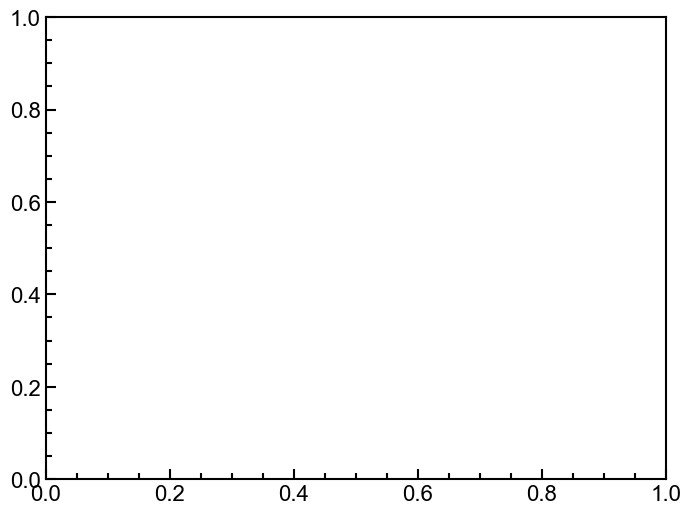

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit

# =========================
# 論文用のスタイル設定
# =========================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# =========================
# 属性名（あなたがクラスに追加したやつ）
# =========================
x_axis_attribute = 'array_starspot'
n_axis_attribute = 'array_flare_number'
t_axis_attribute = 'array_precise_obs_time'
y_axis_attribute = 'array_flare_ratio'   # ★ flare_ratio の配列名（違うならここだけ変えろ）

# =========================
# 表示設定（凡例なし）
# =========================
color_map = {
    'DS Tuc': 'black',
    'EK Dra': (0.8, 0.3, 0.3),
    'V889 Her': (0.3, 0.3, 0.8)
}
marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': 's'}
linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

MARKER_SIZE = 8
CAPSIZE = 2
ELINEWIDTH = 1.2

def power_law(x, a, b):
    return a * x**b

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

# =========================
# メイン
# =========================
if 'all_stars_detectors' in globals() and all_stars_detectors:

    for star_name, detectors_dict in all_stars_detectors.items():
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'o')
        current_linestyle = linestyle_map.get(star_name, '-')

        x_all, y_all, yerr_all = [], [], []

        for det in detectors_dict.values():
            if not (hasattr(det, x_axis_attribute) and hasattr(det, n_axis_attribute) and hasattr(det, t_axis_attribute)):
                continue

            x_arr = np.asarray(getattr(det, x_axis_attribute), dtype=float)
            N_arr = np.asarray(getattr(det, n_axis_attribute), dtype=float)
            T_arr = np.asarray(getattr(det, t_axis_attribute), dtype=float)

            # 空配列はスキップ
            if x_arr.size == 0 or N_arr.size == 0 or T_arr.size == 0:
                continue

            # 長さチェック
            if not (len(x_arr) == len(N_arr) == len(T_arr)):
                print(f"[WARN] {star_name}: len(x)={len(x_arr)} len(N)={len(N_arr)} len(T)={len(T_arr)} 不一致でスキップ")
                continue

            # ---- 各点ごとの frequency と Poisson error ----
            y_calc = N_arr / T_arr
            yerr_arr = np.sqrt(N_arr + 1.0) / T_arr

            # スケール & log用マスク
            x_scaled = x_arr / 1e17
            mask = (
                np.isfinite(x_scaled) & np.isfinite(y_calc) & np.isfinite(yerr_arr) &
                (x_scaled > 0) & (y_calc > 0) & (T_arr > 0) & (N_arr >= 0)
            )

            # === CHECK flare_ratio: flare_ratio と N/T の一致を表示 ===
            if hasattr(det, y_axis_attribute):
                y_ref = np.asarray(getattr(det, y_axis_attribute), dtype=float)

                if y_ref.size == 0:
                    print(f"[CHECK] {star_name}: {y_axis_attribute} is empty")
                elif len(y_ref) != len(N_arr):
                    print(f"[CHECK] {star_name}: len({y_axis_attribute})={len(y_ref)} != len(N)={len(N_arr)}")
                else:
                    # 同じmaskで比較
                    m = mask & np.isfinite(y_ref)
                    if np.any(m):
                        diff = y_calc[m] - y_ref[m]
                        abs_max = np.max(np.abs(diff))
                        abs_med = np.median(np.abs(diff))
                        rel_max = np.max(np.abs(diff) / np.maximum(np.abs(y_ref[m]), 1e-30))

                        # これが欲しい表示
                        #print(f"[CHECK] {star_name}: max|N/T - flare_ratio|={abs_max:.3e}, median={abs_med:.3e}, max_rel={rel_max:.3e}")

                        # もしズレが大きい時だけ先頭を見せる
                        if abs_max > 1e-10:
                            print("  head N:", N_arr[m][:5])
                            print("  head T:", T_arr[m][:5])
                            print("  head N/T:", y_calc[m][:5])
                            print(f"  head {y_axis_attribute}:", y_ref[m][:5])
                    else:
                        print(f"[CHECK] {star_name}: no valid points to compare (after mask)")

            # ---- plot 用に詰める ----
            if np.any(mask):
                x_all.append(x_scaled[mask])
                y_all.append(y_calc[mask])
                yerr_all.append(yerr_arr[mask])

        if len(x_all) == 0:
            continue

        x_all = np.concatenate(x_all)
        y_all = np.concatenate(y_all)
        yerr_all = np.concatenate(yerr_all)

        if len(x_all) < 2:
            continue

        # ---- エラーバー描画（凡例なし） ----
        ax.errorbar(
            x_all, y_all, yerr=yerr_all,
            fmt=current_marker, linestyle='None',
            color=current_color,
            markersize=MARKER_SIZE,
            capsize=CAPSIZE,
            elinewidth=ELINEWIDTH,
            alpha=0.9,
            label=f"{star_name} Data"
        )

        # ---- べき乗フィット（線だけ） ----
        try:
            popt, pcov = curve_fit(
                            power_law,
                            x_all, y_all,
                            sigma=yerr_all,          # ★重み
                            absolute_sigma=True,     # ★pcovを「絶対誤差」として計算
                            maxfev=10000
                        )

            a, b = popt
            a_err, b_err = np.sqrt(np.diag(pcov))

            x_fit = np.linspace(x_all.min(), x_all.max(), 200)
            y_fit = power_law(x_fit, a, b)

            ax.plot(x_fit, y_fit, color=current_color, linestyle=current_linestyle)
            plot_successful = True

            print(f"{star_name}: a = {a:.2e} ± {a_err:.2e}, b = {b:.2f} ± {b_err:.2f}")
        except Exception as e:
            print(f"Could not perform power-law curve_fit for {star_name}: {e}")

    # =========================
    # 軸・目盛り・保存
    # =========================
    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel(r"Flare Frequency (>5×10$^{33}$ erg) [per day]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.04, 1.0)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        ax.set_yticks([0.05,0.1, 0.2, 0.3, 0.4, 0.6, 1.0])
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        ax.legend(loc='lower right',fontsize=15, frameon=False)

        ax.tick_params(axis='both', which='major', labelsize=16)

        fig.tight_layout()
        plt.savefig('analysis_result_freq_with_error_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_freq_with_error_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted (or no fit was successful).")

else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")



Error: 'all_stars_detectors' dictionary not found or is empty.


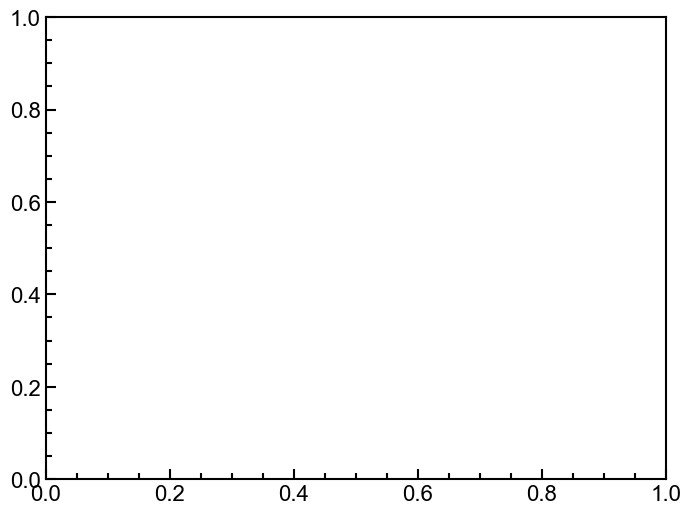

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.optimize import curve_fit

# =========================
# 論文用のスタイル設定
# =========================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# =========================
# 属性名（あなたがクラスに追加したやつ）
# =========================
x_axis_attribute = 'array_starspot'
n_axis_attribute = 'array_flare_number'
t_axis_attribute = 'array_precise_obs_time'
y_axis_attribute = 'array_flare_ratio'   # ★ flare_ratio の配列名（違うならここだけ変えろ）

# =========================
# 表示設定
# =========================
color_map = {
    'DS Tuc': 'black',
    'EK Dra': (0.8, 0.3, 0.3),
    'V889 Her': (0.3, 0.3, 0.8)
}
marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': 's'}
linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

MARKER_SIZE = 8
CAPSIZE = 2
ELINEWIDTH = 1.2

def power_law(x, a, b):
    return a * x**b

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

# =========================
# メイン
# =========================
if 'all_stars_detectors' in globals() and all_stars_detectors:

    for star_name, detectors_dict in all_stars_detectors.items():
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'o')
        current_linestyle = linestyle_map.get(star_name, '-')

        x_all, y_all, yerr_all = [], [], []

        for det in detectors_dict.values():
            if not (hasattr(det, x_axis_attribute) and hasattr(det, n_axis_attribute) and hasattr(det, t_axis_attribute)):
                continue

            x_arr = np.asarray(getattr(det, x_axis_attribute), dtype=float)
            N_arr = np.asarray(getattr(det, n_axis_attribute), dtype=float)
            T_arr = np.asarray(getattr(det, t_axis_attribute), dtype=float)

            # 空配列はスキップ
            if x_arr.size == 0 or N_arr.size == 0 or T_arr.size == 0:
                continue

            # 長さチェック
            if not (len(x_arr) == len(N_arr) == len(T_arr)):
                print(f"[WARN] {star_name}: len(x)={len(x_arr)} len(N)={len(N_arr)} len(T)={len(T_arr)} 不一致でスキップ")
                continue

            # ---- 各点ごとの frequency と Poisson error ----
            y_calc = N_arr / T_arr
            yerr_arr = np.sqrt(N_arr + 1.0) / T_arr

            # スケール & log用マスク
            x_scaled = x_arr / 1e17
            mask = (
                np.isfinite(x_scaled) & np.isfinite(y_calc) & np.isfinite(yerr_arr) &
                (x_scaled > 0) & (y_calc > 0) & (T_arr > 0) & (N_arr >= 0)
            )

            # === CHECK flare_ratio: flare_ratio と N/T の一致を表示 ===
            if hasattr(det, y_axis_attribute):
                y_ref = np.asarray(getattr(det, y_axis_attribute), dtype=float)

                if y_ref.size == 0:
                    print(f"[CHECK] {star_name}: {y_axis_attribute} is empty")
                elif len(y_ref) != len(N_arr):
                    print(f"[CHECK] {star_name}: len({y_axis_attribute})={len(y_ref)} != len(N)={len(N_arr)}")
                else:
                    m = mask & np.isfinite(y_ref)
                    if np.any(m):
                        diff = y_calc[m] - y_ref[m]
                        abs_max = np.max(np.abs(diff))
                        if abs_max > 1e-10:
                            print("  head N:", N_arr[m][:5])
                            print("  head T:", T_arr[m][:5])
                            print("  head N/T:", y_calc[m][:5])
                            print(f"  head {y_axis_attribute}:", y_ref[m][:5])
                    else:
                        print(f"[CHECK] {star_name}: no valid points to compare (after mask)")

            # ---- plot 用に詰める ----
            if np.any(mask):
                x_all.append(x_scaled[mask])
                y_all.append(y_calc[mask])
                yerr_all.append(yerr_arr[mask])

        if len(x_all) == 0:
            continue

        x_all = np.concatenate(x_all)
        y_all = np.concatenate(y_all)
        yerr_all = np.concatenate(yerr_all)

        if len(x_all) < 2:
            continue

        # ---- エラーバー描画（点にlabel） ----
        ax.errorbar(
            x_all, y_all, yerr=yerr_all,
            fmt=current_marker, linestyle='None',
            color=current_color,
            markersize=MARKER_SIZE,
            capsize=CAPSIZE,
            elinewidth=ELINEWIDTH,
            alpha=0.9,
            label=f"{star_name} Data"
        )

        # ---- べき乗フィット（線だけ・凡例には入れない） ----
        try:
            popt, pcov = curve_fit(
                power_law,
                x_all, y_all,
                sigma=yerr_all,
                absolute_sigma=True,
                maxfev=10000
            )

            a, b = popt
            a_err, b_err = np.sqrt(np.diag(pcov))

            x_fit = np.linspace(x_all.min(), x_all.max(), 200)
            y_fit = power_law(x_fit, a, b)

            ax.plot(x_fit, y_fit, color=current_color, linestyle=current_linestyle, label="_nolegend_")
            plot_successful = True

            print(f"{star_name}: a = {a:.2e} ± {a_err:.2e}, b = {b:.2f} ± {b_err:.2f}")
        except Exception as e:
            print(f"Could not perform power-law curve_fit for {star_name}: {e}")

    # =========================
    # 軸・目盛り・保存（★ここだけ綺麗にする）
    # =========================
    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel(r"Flare Frequency (>5×10$^{33}$ erg) [per day]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.04, 1.0)

        ax.set_xscale('log')
        ax.set_yscale('log')

        # --- major ticks: あなたの好み（0.5,1,2,3,5）を維持 ---
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1.0])

        # 表示を "0.50" じゃなく "0.5" / "1" / "2" にする
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))

        # --- minor ticks: logらしい補助目盛り（線だけ、数字は出さない） ---
        ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())
        ax.yaxis.set_minor_formatter(mticker.NullFormatter())

        # --- tickの見た目（上下左右に出すと論文っぽい） ---
        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False)
        ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=16)
        ax.tick_params(axis='both', which='minor', length=4, width=1.2)

        ax.legend(loc='lower right', fontsize=15, frameon=False)

        fig.tight_layout()
        plt.savefig('analysis_result_freq_with_error_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_freq_with_error_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted (or no fit was successful).")

else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")



Error: 'all_stars_detectors' dictionary not found or is empty.


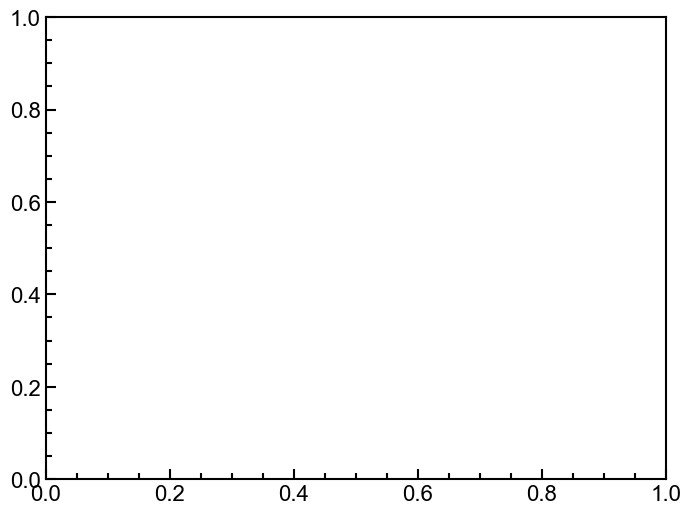

In [7]:
import matplotlib.ticker as mticker

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_flare_ratio'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3), # 例: 彩度を抑えた赤
        'V889 Her': (0.3, 0.3, 0.8) # 例: 彩度を抑えた青
        }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

    for i, (star_name, detectors_dict) in enumerate(all_stars_detectors.items()):
        # ... (データ収集・スケーリング部分は変更なし) ...
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'x')
        current_linestyle = linestyle_map.get(star_name, '-')
        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)
                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17

            ax.scatter(x_data_scaled, y_data, label=f'{star_name} Data', color=current_color, alpha=0.9, marker=current_marker, s=marker_size)

            from scipy.optimize import curve_fit

        # べき乗モデル
        def power_law(x, a, b):
            return a * x**b

        try:
            # log 軸なので 0 や負の値を除外（重要）
            mask = (x_data_scaled > 0) & (y_data > 0)
            x_fit_data = x_data_scaled[mask]
            y_fit_data = y_data[mask]

            popt, pcov = curve_fit(power_law, x_fit_data, y_fit_data)

            a, b = popt
            a_err, b_err = np.sqrt(np.diag(pcov))

            x_fit = np.linspace(x_fit_data.min(), x_fit_data.max(), 200)
            y_fit = power_law(x_fit, a, b)

            ax.plot(x_fit, y_fit,
                    color=current_color,
                    linestyle=current_linestyle)

            plot_successful = True

            # 確認用
            print(f"{star_name}: a = {a:.2e} ± {a_err:.2e}, b = {b:.2f} ± {b_err:.2f}")

        except Exception as e:
            print(f"Could not perform power-law curve_fit for {star_name}: {e}")


    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Flare Frequency (>5×$10^{33}$erg) [per day]", fontsize=17)

        # ★追加: X軸の範囲を設定
        ax.set_xlim(0.5, 8) # 例: X軸を 0 から 10 の範囲に設定
        # ★追加: Y軸の範囲を設定
        ax.set_ylim(0.07, 0.7) # 例: Y軸を 0 から 60 の範囲に設定

        # ★★★ 2. 軸をログスケールに変更（必要に応じてコメントを外す） ★★★
        ax.set_yscale('log')
        ax.set_xscale('log')

        # ★ 2. X軸の主目盛りの表示形式を通常の数値に変更 ★
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        # X軸の補助目盛りが指数表示になるのを防ぐ（任意）
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        ax.set_yticks([0.1 , 0.2 , 0.3 ,0.4 , 0.6 ])
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

        # ax.legend() の引数に frameon=False を追加するだけ
        ax.legend(loc='lower right',fontsize=15, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=16)
        #ax.grid(True)
        fig.tight_layout()
        plt.savefig('analysis_result_freq_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_number_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


Error: 'all_stars_detectors' dictionary not found or is empty.


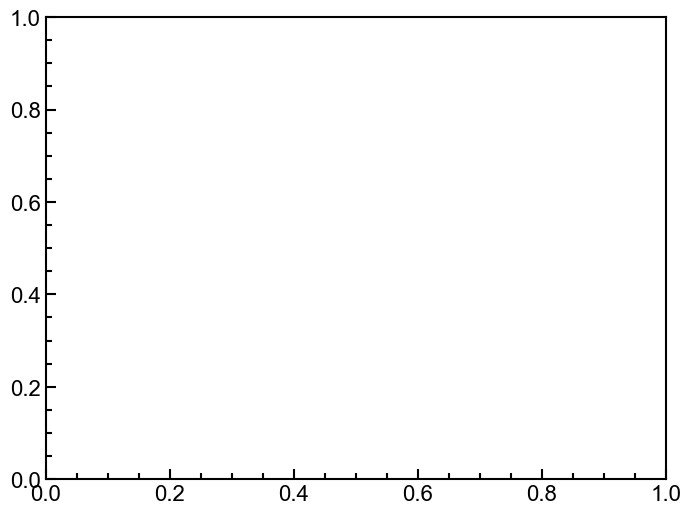

In [8]:
import matplotlib.ticker as mticker

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_sum_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3), # 例: 彩度を抑えた赤
        'V889 Her': (0.3, 0.3, 0.8) # 例: 彩度を抑えた青
        }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

    for i, (star_name, detectors_dict) in enumerate(all_stars_detectors.items()):
        # ... (データ収集・スケーリング部分は変更なし) ...
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'x')
        current_linestyle = linestyle_map.get(star_name, '-')
        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)
                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17
            y_data_scaled = y_data / 1e35

            ax.scatter(x_data_scaled, y_data_scaled, label=f'{star_name} Data', color=current_color, alpha=0.9, marker=current_marker, s=marker_size)

        from scipy.optimize import curve_fit

        # べき乗モデル
        def power_law(x, a, b):
            return a * x**b

        try:
            # log 軸なので 0 や負の値を除外（重要）
            mask = (x_data_scaled > 0) & (y_data_scaled > 0)
            x_fit_data = x_data_scaled[mask]
            y_fit_data = y_data_scaled[mask]

            popt, pcov = curve_fit(power_law, x_fit_data, y_fit_data)

            a, b = popt
            a_err, b_err = np.sqrt(np.diag(pcov))

            x_fit = np.linspace(x_fit_data.min(), x_fit_data.max(), 200)
            y_fit = power_law(x_fit, a, b)

            ax.plot(x_fit, y_fit,
                    color=current_color,
                    linestyle=current_linestyle)

            plot_successful = True

            # 確認用
            print(f"{star_name}: a = {a:.2e} ± {a_err:.2e}, b = {b:.2f} ± {b_err:.2f}")

        except Exception as e:
            print(f"Could not perform power-law curve_fit for {star_name}: {e}")

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Total Flare Energy (>5×$10^{33}$erg)[10$^{35}$ erg]", fontsize=17)

        # ★追加: X軸の範囲を設定
        ax.set_xlim(0.5, 8) # 例: X軸を 0 から 10 の範囲に設定
        # ★追加: Y軸の範囲を設定
        ax.set_ylim(0.1, 7) # 例: Y軸を 0 から 60 の範囲に設定

        # ★★★ 2. 軸をログスケールに変更（必要に応じてコメントを外す） ★★★
        ax.set_yscale('log')
        ax.set_xscale('log')

        # ★ 2. X軸の主目盛りの表示形式を通常の数値に変更 ★
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        # X軸の補助目盛りが指数表示になるのを防ぐ（任意）
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        ax.set_yticks([0.1 , 0.2 , 0.3 ,0.5 , 1.0 , 2.0 , 3.0 ])
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

        # ax.legend() の引数に frameon=False を追加するだけ
        ax.legend(loc='lower right',fontsize=15, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=16)
        #ax.grid(True)
        fig.tight_layout()
        plt.savefig('analysis_result_totalene_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_total_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


Error: 'all_stars_detectors' dictionary not found or is empty.


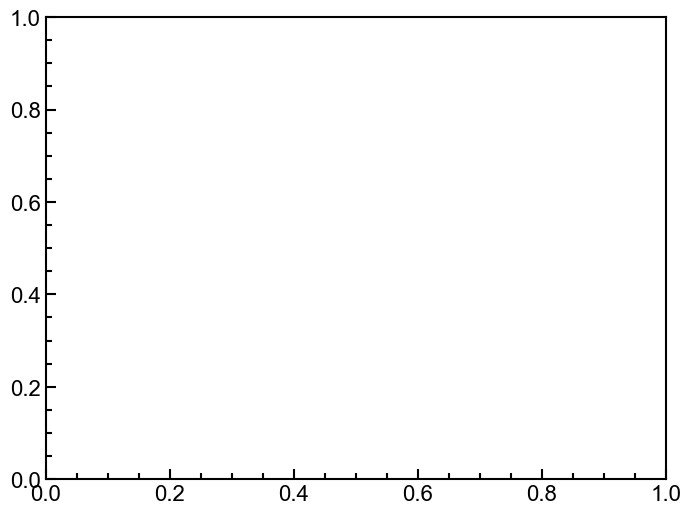

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_sum_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3), # 例: 彩度を抑えた赤
        'V889 Her': (0.3, 0.3, 0.8) # 例: 彩度を抑えた青
        }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': 's'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

    for i, (star_name, detectors_dict) in enumerate(all_stars_detectors.items()):
        # ... (データ収集・スケーリング部分は変更なし) ...
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'x')
        current_linestyle = linestyle_map.get(star_name, '-')
        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)
                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17
            y_data_scaled = y_data / 1e35

            ax.scatter(
                x_data_scaled, y_data_scaled,
                label=f'{star_name} Data',
                color=current_color,
                alpha=0.9,
                marker=current_marker,
                s=marker_size
            )

        from scipy.optimize import curve_fit

        # べき乗モデル
        def power_law(x, a, b):
            return a * x**b

        try:
            # log 軸なので 0 や負の値を除外（重要）
            mask = (x_data_scaled > 0) & (y_data_scaled > 0)
            x_fit_data = x_data_scaled[mask]
            y_fit_data = y_data_scaled[mask]

            popt, pcov = curve_fit(power_law, x_fit_data, y_fit_data)

            a, b = popt
            a_err, b_err = np.sqrt(np.diag(pcov))

            x_fit = np.linspace(x_fit_data.min(), x_fit_data.max(), 200)
            y_fit = power_law(x_fit, a, b)

            ax.plot(x_fit, y_fit,
                    color=current_color,
                    linestyle=current_linestyle)

            plot_successful = True

            # 確認用
            print(f"{star_name}: a = {a:.2e} ± {a_err:.2e}, b = {b:.2f} ± {b_err:.2f}")

        except Exception as e:
            print(f"Could not perform power-law curve_fit for {star_name}: {e}")

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Total Flare Energy (>5×$10^{33}$erg)[10$^{35}$ erg]", fontsize=17)

        # 範囲
        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.1, 7)

        # log
        ax.set_yscale('log')
        ax.set_xscale('log')

        # =========================
        # ★ 目盛り（ここだけ調整）
        # =========================
        # major ticks（あなたの指定を維持）
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0])

        # 0.50 -> 0.5, 1.00 -> 1 みたいに綺麗に
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))

        # minor ticks（logらしい補助目盛り）※数字は出さない
        ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())
        ax.yaxis.set_minor_formatter(mticker.NullFormatter())

        # 上・右は不要（下・左だけ）
        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False)
        ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=16)
        ax.tick_params(axis='both', which='minor', length=4, width=1.2)

        # legend
        ax.legend(loc='lower right', fontsize=15, frameon=False)

        fig.tight_layout()
        plt.savefig('analysis_result_totalene_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_total_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")



Error: 'all_stars_detectors' dictionary not found or is empty.


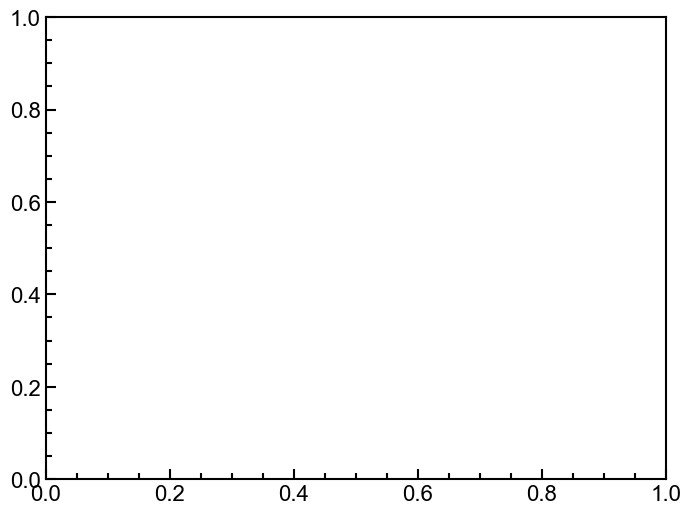

In [10]:
import matplotlib.ticker as mticker

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_max_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3), # 例: 彩度を抑えた赤
        'V889 Her': (0.3, 0.3, 0.8) # 例: 彩度を抑えた青
        }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

    for i, (star_name, detectors_dict) in enumerate(all_stars_detectors.items()):
        # ... (データ収集・スケーリング部分は変更なし) ...
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'x')
        current_linestyle = linestyle_map.get(star_name, '-')
        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)
                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17
            y_data_scaled = y_data / 1e34

            ax.scatter(x_data_scaled, y_data_scaled, label=f'{star_name} Data', color=current_color, alpha=0.9, marker=current_marker, s=marker_size)


            plot_successful = True


    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Max Flare Energy [10$^{34}$ erg]", fontsize=17)

        # ★追加: X軸の範囲を設定
        ax.set_xlim(0.5, 8) # 例: X軸を 0 から 10 の範囲に設定
        # ★追加: Y軸の範囲を設定
        ax.set_ylim(0.5,45) # 例: Y軸を 0 から 60 の範囲に設定

        # ★★★ 2. 軸をログスケールに変更（必要に応じてコメントを外す） ★★★
        ax.set_yscale('log')
        ax.set_xscale('log')

        # ★ 2. X軸の主目盛りの表示形式を通常の数値に変更 ★
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        # X軸の補助目盛りが指数表示になるのを防ぐ（任意）
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        ax.set_yticks([0.5 , 1.0 , 2.0 , 3.0 , 5.0 , 10.0 ,20.0 ])
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

        # ax.legend() の引数に frameon=False を追加するだけ
        ax.legend(loc='lower right',fontsize=15, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=16)
        #ax.grid(True)
        fig.tight_layout()
        plt.savefig('analysis_result_maxene_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_max_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


Error: 'all_stars_detectors' dictionary not found or is empty.


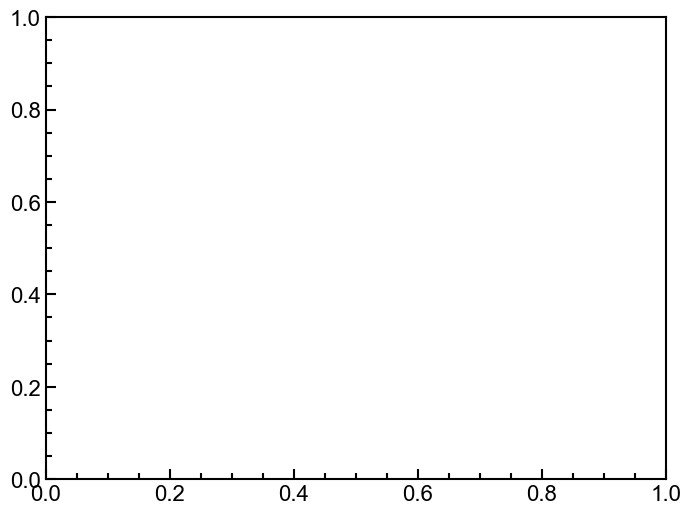

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---

x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_max_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3), # 例: 彩度を抑えた赤
        'V889 Her': (0.3, 0.3, 0.8) # 例: 彩度を抑えた青
        }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': 's'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}

    for i, (star_name, detectors_dict) in enumerate(all_stars_detectors.items()):
        # ... (データ収集・スケーリング部分は変更なし) ...
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'x')
        current_linestyle = linestyle_map.get(star_name, '-')
        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)
                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star)
            y_data = np.array(y_data_for_star)
            x_data_scaled = x_data / 1e17
            y_data_scaled = y_data / 1e34

            ax.scatter(
                x_data_scaled, y_data_scaled,
                label=f'{star_name} Data',
                color=current_color,
                alpha=0.9,
                marker=current_marker,
                s=marker_size
            )

            plot_successful = True

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Max Flare Energy [10$^{34}$ erg]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.5, 45)

        ax.set_yscale('log')
        ax.set_xscale('log')

        # =========================
        # ★ 目盛り（ここだけ調整）
        # =========================
        # major ticks（あなたの指定を維持）
        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.set_yticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0])

        # 0.50 -> 0.5, 1.00 -> 1 のように綺麗に
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f"{x:g}"))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:g}"))

        # minor ticks（logらしい補助目盛り）※数字は出さない
        ax.xaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.yaxis.set_minor_locator(mticker.LogLocator(base=10, subs=np.arange(2, 10) * 0.1))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())
        ax.yaxis.set_minor_formatter(mticker.NullFormatter())

        # 上・右は不要（下・左だけ）
        ax.tick_params(axis='both', which='both', direction='in', top=False, right=False)
        ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=16)
        ax.tick_params(axis='both', which='minor', length=4, width=1.2)

        ax.legend(loc='lower right', fontsize=15, frameon=False)

        fig.tight_layout()
        plt.savefig('analysis_result_maxene_plot.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_max_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")



Error: 'all_stars_detectors' dictionary not found or is empty.


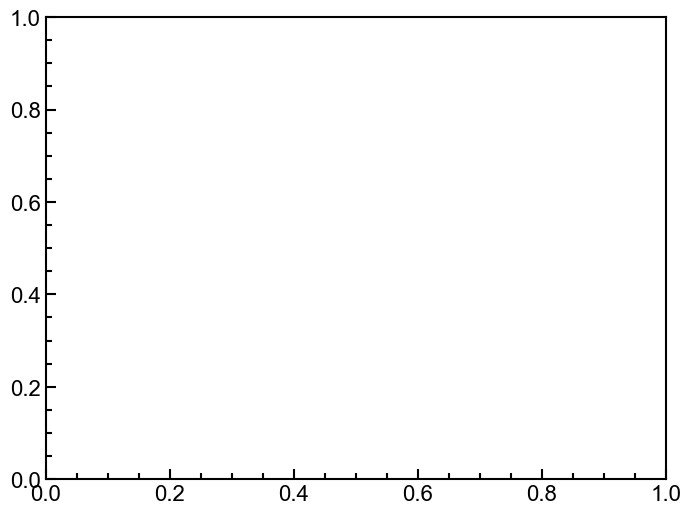

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import pearsonr

# --- 論文用のスタイル設定 ---
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

# --- ここからグラフ作成処理 ---
x_axis_attribute = 'array_starspot'
y_axis_attribute = 'array_max_energy'

fig, ax = plt.subplots(figsize=(8, 6))
plot_successful = False

if 'all_stars_detectors' in locals() and all_stars_detectors:
    color_map = {
        'DS Tuc': 'black',
        'EK Dra': (0.8, 0.3, 0.3),
        'V889 Her': (0.3, 0.3, 0.8)
    }
    marker_map = {'DS Tuc': 'o', 'EK Dra': 'x', 'V889 Her': '+'}
    marker_size = 100
    linestyle_map = {'DS Tuc': '-', 'EK Dra': '--', 'V889 Her': ':'}  # 使ってないけど残してOK

    for star_name, detectors_dict in all_stars_detectors.items():
        current_color = color_map.get(star_name, 'grey')
        current_marker = marker_map.get(star_name, 'x')

        x_data_for_star = []
        y_data_for_star = []

        for det_instance in detectors_dict.values():
            if hasattr(det_instance, x_axis_attribute) and hasattr(det_instance, y_axis_attribute):
                x_array = getattr(det_instance, x_axis_attribute)
                y_array = getattr(det_instance, y_axis_attribute)

                if isinstance(x_array, (list, np.ndarray)) and isinstance(y_array, (list, np.ndarray)) and len(x_array) == len(y_array):
                    x_data_for_star.extend(x_array)
                    y_data_for_star.extend(y_array)

        if len(x_data_for_star) > 1:
            x_data = np.array(x_data_for_star, dtype=float)
            y_data = np.array(y_data_for_star, dtype=float)

            # NaN/inf を除去
            valid = np.isfinite(x_data) & np.isfinite(y_data)
            x_data = x_data[valid]
            y_data = y_data[valid]

            # スケーリング（表示用）
            x_data_scaled = x_data / 1e17
            y_data_scaled = y_data / 1e34

            # Pearson（相関は「スケーリングしてもしなくても同じ」だけど、ここではスケーリング後で計算）
            r_str, p_str = "NA", "NA"
            if len(x_data_scaled) >= 2:
                # 定数配列だと pearsonr がエラー/警告になるので弾く
                if np.nanstd(x_data_scaled) > 0 and np.nanstd(y_data_scaled) > 0:
                    try:
                        r, p = pearsonr(x_data_scaled, y_data_scaled)
                        r_str = f"{r:.2f}"
                        # pは桁が小さくなりがちなので見やすく
                        p_str = f"{p:.2e}"
                    except Exception:
                        pass

            label = f"{star_name} (r={r_str}, p={p_str}, N={len(x_data_scaled)})"

            ax.scatter(
                x_data_scaled,
                y_data_scaled,
                label=label,
                color=current_color,
                alpha=0.9,
                marker=current_marker,
                s=marker_size
            )

            plot_successful = True

    if plot_successful:
        ax.set_xlabel(r"Starspot Area [10$^{21}$ cm$^2$]", fontsize=17)
        ax.set_ylabel("Max Flare Energy [10$^{34}$ erg]", fontsize=17)

        ax.set_xlim(0.5, 8)
        ax.set_ylim(0.5, 45)

        ax.set_yscale('log')
        ax.set_xscale('log')

        ax.set_xticks([0.5, 1.0, 2.0, 3.0, 5.0])
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax.xaxis.set_minor_formatter(mticker.NullFormatter())

        ax.set_yticks([0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0])
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

        ax.legend(loc='lower right', fontsize=15, frameon=False)
        ax.tick_params(axis='both', which='major', labelsize=16)

        fig.tight_layout()
        plt.savefig('analysis_result_maxene_plot_pearsonr.pdf', format='pdf', bbox_inches='tight')
        print("\nPlot saved as 'analysis_result_maxene_plot.pdf'")
        plt.show()
    else:
        print("\nNo data was plotted.")
else:
    print("\nError: 'all_stars_detectors' dictionary not found or is empty.")


In [13]:
plt.rcParams['font.family'] = 'Meiryo'
# 例：macOSの場合
# plt.rcParams['font.family'] = 'Hiragino Sans'

# フォントサイズもここでまとめて設定可能
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 23  # 軸ラベル
plt.rcParams['xtick.labelsize'] = 13 # x軸の目盛り
plt.rcParams['ytick.labelsize'] = 13 # y軸の目盛り
plt.rcParams['legend.fontsize'] = 12 # 凡例
plt.rcParams['figure.titlesize'] = 30# タイトル



array_rot_period = [0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    0.2094793179536128,
                    ]

class_var_name_x = 'array_starspot'         # ★ X軸に対応するクラス変数名
class_var_name_y = 'array_flare_ratio'   # ★ Y軸に対応するクラス変数名

plt.figure(figsize=(12, 8))
plot_successful = False

colors = plt.cm.viridis(np.linspace(0, 1, len(STAR_INFO))) # 各クラスに異なる色を割り当て


for i, (star_key_in_map, TargetDetectorClass) in enumerate(STAR_INFO.items()):
    print(f"\nProcessing class: {TargetDetectorClass.__module__}.{TargetDetectorClass.__name__} (for star key: '{star_key_in_map}')")

    # 2つのクラス変数がクラスに存在するか確認
    if hasattr(TargetDetectorClass, class_var_name_x) and \
       hasattr(TargetDetectorClass, class_var_name_y):

        class_var_x_values = getattr(TargetDetectorClass, class_var_name_x)
        class_var_y_values = getattr(TargetDetectorClass, class_var_name_y)

        print(f"  Found '{class_var_name_x}': {class_var_x_values}")
        print(f"  Found '{class_var_name_y}': {class_var_y_values}")

        # 値がプロット可能な数値配列であり、長さが同じであることを確認
        is_x_valid = isinstance(class_var_x_values, (list, tuple, np.ndarray)) and \
                     all(isinstance(item, (int, float, np.number)) for item in class_var_x_values)
        is_y_valid = isinstance(class_var_y_values, (list, tuple, np.ndarray)) and \
                     all(isinstance(item, (int, float, np.number)) for item in class_var_y_values)

        if is_x_valid and is_y_valid:
            # NumPy配列に変換
            x_data = np.array(class_var_x_values)
            y_data = np.array(class_var_y_values)

            if len(x_data) == len(y_data) and len(x_data) > 1: # データ点が2つ以上必要
                # 散布図をプロット
                plt.scatter(x_data, y_data, label=f'{star_key_in_map} Data', color=colors[i], alpha=0.7)

                # 線形フィッティング (y = mx + c)
                # deg=1 は線形フィットを意味する
                try:
                    coeffs = np.polyfit(x_data, y_data, 1) # [傾き m, 切片 c]
                    poly = np.poly1d(coeffs)
                    y_fit = poly(x_data)

                    # フィッティング直線をプロット
                    plt.plot(x_data, y_fit, color=colors[i], linestyle='-',
                             label=f'{star_key_in_map}')
                    #print(f"  Fit for {star_key_in_map}: slope={coeffs[0]:.2f}, intercept={coeffs[1]:.2f}")
                    plot_successful = True

                except np.linalg.LinAlgError:
                    print(f"  Could not perform linear fit for {star_key_in_map} (LinAlgError). Skipping fit line.")
                except Exception as e:
                    print(f"  Error during fitting for {star_key_in_map}: {e}. Skipping fit line.")

            elif len(x_data) != len(y_data):
                print(f"  Class variables '{class_var_name_x}' and '{class_var_name_y}' have different lengths. Skipping plot for {star_key_in_map}.")
            else: # len(x_data) <= 1
                 print(f"  Not enough data points (<=1) for fitting for {star_key_in_map}. Skipping plot.")
        else:
            print(f"  One or both class variables are not lists/tuples/arrays of numbers for {star_key_in_map}.")
    else:
        missing_vars = []
        if not hasattr(TargetDetectorClass, class_var_name_x):
            missing_vars.append(class_var_name_x)
        if not hasattr(TargetDetectorClass, class_var_name_y):
            missing_vars.append(class_var_name_y)
        print(f"  Class variable(s) '{', '.join(missing_vars)}' not found in {TargetDetectorClass.__name__}. Skipping this class.")

if plot_successful:
    # フォントサイズを指定 (数値はお好みで調整してください)
    label_fontsize = 23
    title_fontsize = 30
    legend_fontsize = 12
    tick_fontsize = 13  # 目盛りラベルのフォントサイズ

    plt.xlabel(f"黒点面積 (m^2)", fontsize=label_fontsize)
    plt.ylabel(f"フレア発生頻度 (/日)", fontsize=label_fontsize)
    #plt.title(f"Fig.4  Starspot Area vs Flare Frequency ", fontsize=title_fontsize)
    plt.legend(fontsize=legend_fontsize)

    # X軸とY軸の目盛りラベルのフォントサイズも設定できます
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    plt.grid(True)
    plt.tight_layout() # ラベルが重ならないように調整
    plt.show()
else:
    print(f"\nNo plots were generated. Ensure '{class_var_name_x}' and '{class_var_name_y}' are valid class variables "
          f"containing arrays of numbers of the same length in the mapped FlareDetector classes.")

AttributeError: 'dict' object has no attribute '__module__'

<Figure size 1200x800 with 0 Axes>


Processing class: flarepy_EK_Dra.FlareDetector (for star key: 'EK Dra')
  Found 'array_starspot_ratio': []
  Found 'array_flare_ratio': []

Processing class: flarepy_V889_Her.FlareDetector (for star key: 'V889 Her')
  Found 'array_starspot_ratio': [0.06328287 0.0388731  0.05264869 0.02432979 0.06328287 0.0388731
 0.05264869 0.02432979]
  Found 'array_flare_ratio': [0.62651495 0.44007891 0.3714661  0.27474633 0.62651495 0.44007891
 0.3714661  0.27474633]
  Fit for V889 Her (log-log): y = C*x^m, m=0.70, C=3.72e+00

Processing class: flarepy_DS_Tuc.FlareDetector (for star key: 'DS Tuc')
  Found 'array_starspot_ratio': [0.07409205 0.1079482  0.08407876 0.05535515 0.07143343 0.07409205
 0.1079482  0.08407876 0.05535515 0.07143343]
  Found 'array_flare_ratio': [0.26390323 0.38566323 0.46948776 0.18802307 0.36840673 0.26390323
 0.38566323 0.46948776 0.18802307 0.36840673]
  Fit for DS Tuc (log-log): y = C*x^m, m=1.13, C=5.83e+00


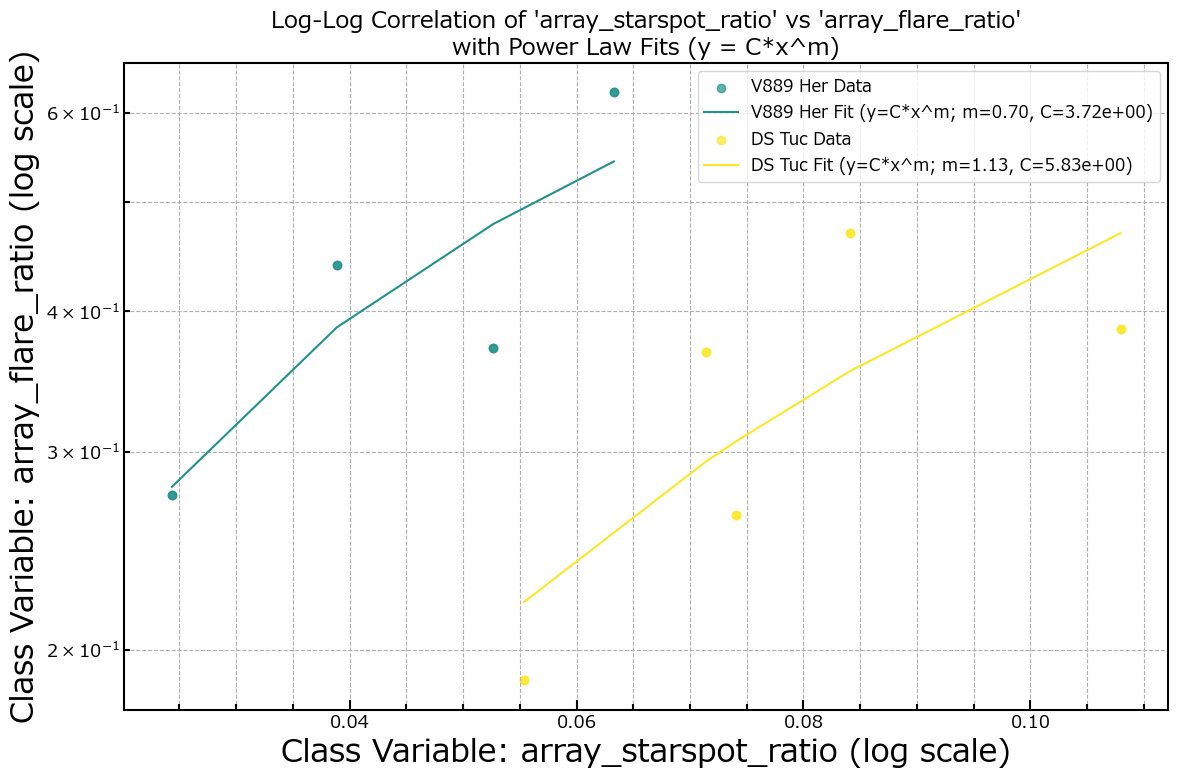

In [ ]:
class_var_name_x = 'array_starspot_ratio'         # ★ X軸に対応するクラス変数名
class_var_name_y = 'array_flare_ratio'   # ★ Y軸に対応するクラス変数名

plt.figure(figsize=(12, 8))
plot_successful = False

colors = plt.cm.viridis(np.linspace(0, 1, len(STAR_CLASS_MAP))) # 各クラスに異なる色を割り当て

for i, (star_key_in_map, TargetDetectorClass) in enumerate(STAR_CLASS_MAP.items()):
    print(f"\nProcessing class: {TargetDetectorClass.__module__}.{TargetDetectorClass.__name__} (for star key: '{star_key_in_map}')")

    # 2つのクラス変数がクラスに存在するか確認
    if hasattr(TargetDetectorClass, class_var_name_x) and \
       hasattr(TargetDetectorClass, class_var_name_y):

        class_var_x_values = getattr(TargetDetectorClass, class_var_name_x)
        class_var_y_values = getattr(TargetDetectorClass, class_var_name_y)

        print(f"  Found '{class_var_name_x}': {class_var_x_values}")
        print(f"  Found '{class_var_name_y}': {class_var_y_values}")

        # 値がプロット可能な数値配列であり、長さが同じであることを確認
        is_x_valid = isinstance(class_var_x_values, (list, tuple, np.ndarray)) and \
                     all(isinstance(item, (int, float, np.number)) for item in class_var_x_values)
        is_y_valid = isinstance(class_var_y_values, (list, tuple, np.ndarray)) and \
                     all(isinstance(item, (int, float, np.number)) for item in class_var_y_values)

        if is_x_valid and is_y_valid:
            # NumPy配列に変換
            x_data = np.array(class_var_x_values)
            y_data = np.array(class_var_y_values)

            if len(x_data) == len(y_data) and len(x_data) > 1: # データ点が2つ以上必要
                # 散布図をプロット
                plt.scatter(x_data, y_data, label=f'{star_key_in_map} Data', color=colors[i], alpha=0.7)
                try:
                    # 1. データを対数変換 (log10を使用)
                    log_x_data = np.log10(x_data)
                    log_y_data = np.log10(y_data)

                    # 2. 対数変換したデータで線形フィット
                    # coeffs_log[0] は傾き m, coeffs_log[1] は log10(C)
                    coeffs_log = np.polyfit(log_x_data, log_y_data, 1)
                    m_log = coeffs_log[0]
                    log10_C = coeffs_log[1]

                    # 3. フィット線を元のスケールに戻してプロット (またはlogスケール上で)
                    #    x_data_plot はソートしておくと線が綺麗
                    x_fit_line_sorted = np.sort(x_data)
                    # y = C * x^m  => log10(y) = m * log10(x) + log10(C)
                    # なので、y_fit = 10**(m_log * np.log10(x_fit_line_sorted) + log10_C)
                    y_fit_on_original_scale = 10**(m_log * np.log10(x_fit_line_sorted) + log10_C)

                    plt.plot(x_fit_line_sorted, y_fit_on_original_scale, color=colors[i], linestyle='-',
                             label=f'{star_key_in_map} Fit (y=C*x^m; m={m_log:.2f}, C={10**log10_C:.2e})')
                    print(f"  Fit for {star_key_in_map} (log-log): y = C*x^m, m={m_log:.2f}, C={10**log10_C:.2e}")
                    plot_successful = True

                except np.linalg.LinAlgError:
                    print(f"  Could not perform log-log linear fit for {star_key_in_map} (LinAlgError). Skipping fit line.")
                except ValueError as ve: # np.log10 に0以下の値が入った場合など
                    print(f"  ValueError during log transformation or fit for {star_key_in_map}: {ve}. Skipping fit line.")
                except Exception as e:
                    print(f"  Error during log-log fitting for {star_key_in_map}: {e}. Skipping fit line.")

# ... (ループの後) ...

if plot_successful:
    plt.xscale('linear') # 4. 軸をlogスケールに
    plt.yscale('log') # 4. 軸をlogスケールに

    plt.xlabel(f"Class Variable: {class_var_name_x} (log scale)")
    plt.ylabel(f"Class Variable: {class_var_name_y} (log scale)")
    plt.title(f"Log-Log Correlation of '{class_var_name_x}' vs '{class_var_name_y}'\nwith Power Law Fits (y = C*x^m)")
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
else:
    print("No data was successfully plotted or fit.")


In [ ]:
print("available keys:", list(all_stars_detectors.keys()))


available keys: ['DS Tuc', 'EK Dra', 'V889 Her']


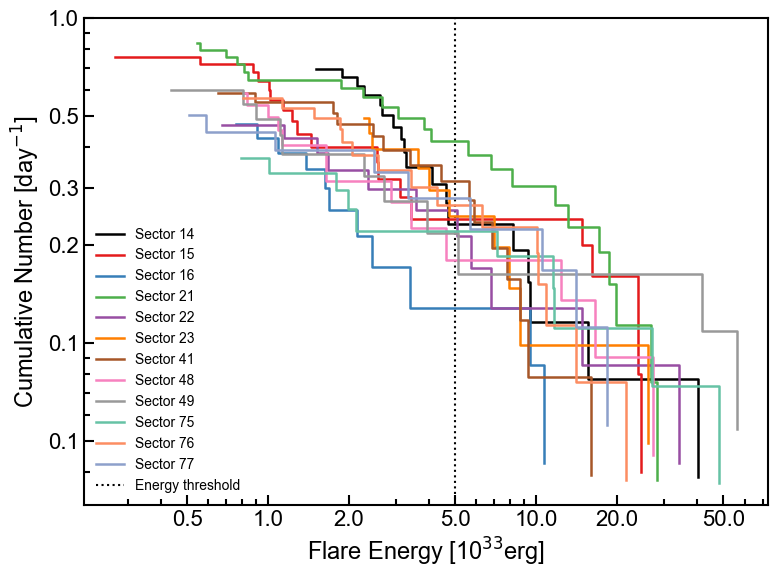

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
# values() だけだと sector 情報（detector_sXXXX）が失われるので items() を使う
detector_items = list(all_stars_detectors["EK Dra"].items())  # (detector_s0001, instance) のリスト

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A",
    "#984EA3", "#FF7F00", "#A65628", "#F781BF",
    "#999999", "#66C2A5", "#FC8D62", "#8DA0CB",
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, (det_name, det) in enumerate(detector_items):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    # det_name は "detector_s0001" の想定 → "Sector 1" にする
    try:
        s = det_name.split("_")[-1]      # "s0001"
        sector_num = int(s[1:])          # 1
        label = f"Sector {sector_num}"
    except Exception:
        # 万一想定外の名前でも落ちないように保険
        label = det_name

    ax.step(
        energy_cor / 1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=label,   # ←ここが Sector 表示
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)

ax.set_xticks([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05, 0.1, 0.2, 0.3, 0.5, 1])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig("flare_cumenergy_EKDra.pdf", format="pdf", bbox_inches="tight")
plt.show()


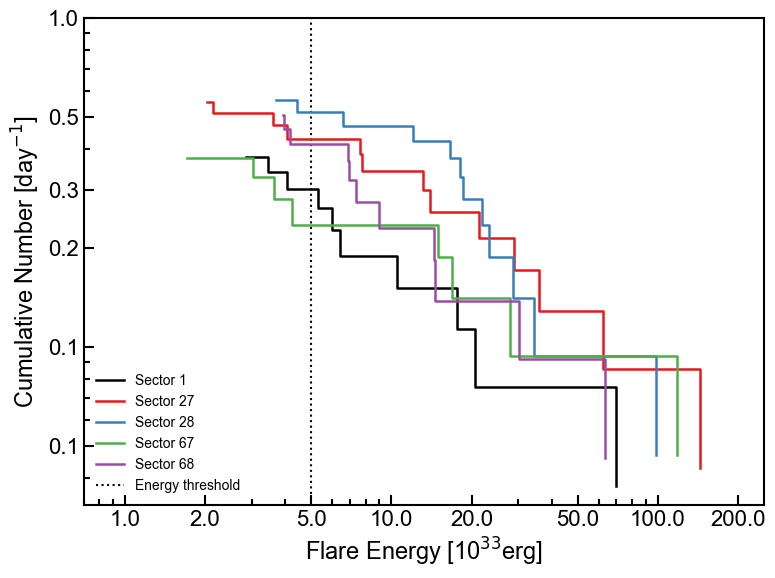

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
detector_items = list(all_stars_detectors["DS Tuc"].items())

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A",
    "#984EA3"
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, (det_name, det) in enumerate(detector_items):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    # det_name は "detector_s0001" の想定 → "Sector 1" にする
    try:
        s = det_name.split("_")[-1]      # "s0001"
        sector_num = int(s[1:])          # 1
        label = f"Sector {sector_num}"
    except Exception:
        # 万一想定外の名前でも落ちないように保険
        label = det_name

    ax.step(
        energy_cor / 1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=label,   # ←ここが Sector 表示
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)


ax.set_xticks([1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100, 200])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
# X軸の補助目盛りが指数表示になるのを防ぐ（任意）
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05 , 0.1 , 0.2 , 0.3 , 0.5 , 1 ])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

ax.set_xlim(0.7, 250)


# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig("flare_cumenergy_DSTuc.pdf", format="pdf", bbox_inches="tight")
plt.show()


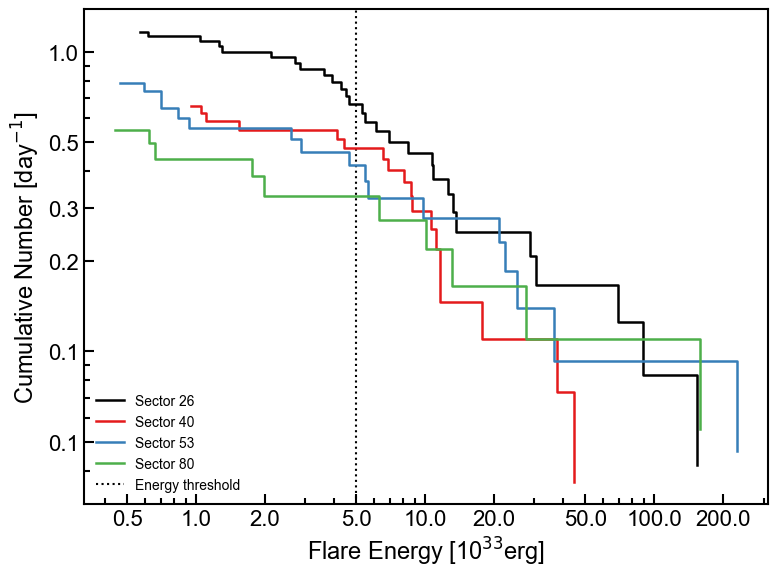

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ===============================
# 論文用スタイル設定（そのまま流用）
# ===============================
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.minor.width'] = 1.5
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# ===============================
# データ取得
# ===============================
detector_items = list(all_stars_detectors["V889 Her"].items())

colors = [
    "#000000", "#E41A1C", "#377EB8", "#4DAF4A"
]

# ===============================
# Figure 作成
# ===============================
fig, ax = plt.subplots(figsize=(8, 6))

# ===============================
# 各インスタンスを描画
# ===============================
for i, (det_name, det) in enumerate(detector_items):
    if det.energy is None or len(det.energy) == 0:
        continue

    color = colors[i % len(colors)]

    energy_cor = np.sort(det.energy)
    cumenergy = np.array([len(energy_cor) - j for j in range(len(energy_cor))])
    rate = cumenergy / det.precise_obs_time

    # det_name は "detector_s0001" の想定 → "Sector 1" にする
    try:
        s = det_name.split("_")[-1]      # "s0001"
        sector_num = int(s[1:])          # 1
        label = f"Sector {sector_num}"
    except Exception:
        # 万一想定外の名前でも落ちないように保険
        label = det_name

    ax.step(
        energy_cor / 1e33,
        rate,
        where="post",
        color=color,
        linewidth=1.8,
        label=label,   # ←ここが Sector 表示
    )

# ===============================
# 軸設定（論文向け）
# ===============================
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Flare Energy [10$^{33}$erg]", fontsize=17)
ax.set_ylabel(r"Cumulative Number [day$^{-1}$]", fontsize=17)

ax.tick_params(labelsize=16)

ax.axvline(
    x=5,
    color="black",
    linestyle="dotted",
    linewidth=1.5,
    label="Energy threshold",
    zorder=0
)


ax.set_xticks([0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100, 200])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
# X軸の補助目盛りが指数表示になるのを防ぐ（任意）
ax.xaxis.set_minor_formatter(mticker.NullFormatter())

ax.set_yticks([0.05 , 0.1 , 0.2 , 0.3 , 0.5 , 1 ])
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# ===============================
# Legend（枠なし）
# ===============================
leg = ax.legend(
    loc="lower left",
    fontsize=10,
    frameon=True,
)
leg.get_frame().set_alpha(0)

# ===============================
# 保存・表示
# ===============================
plt.tight_layout()
plt.savefig("flare_cumenergy_V889Her.pdf", format="pdf", bbox_inches="tight")
plt.show()


# Migration Verification
The following cells reproduce the plots using the new `src.visualization` module.  
These plots should be identical to the ones generated by the legacy code cells above.

In [ ]:
# 1. Flare Frequency Plot (Reproducing Legacy Cell 3-6)
print("Plotting Migrated Flare Frequency...")
fig_freq = plot_flare_frequency(
    all_stars_detectors,
    output_filename="migrated_freq_plot.pdf"
)

In [ ]:
# 2. Total Flare Energy Plot (Reproducing Legacy Cell 7-8)
print("Plotting Migrated Total Energy...")
fig_total = plot_total_energy(
    all_stars_detectors,
    output_filename="migrated_totalene_plot.pdf"
)

In [ ]:
# 3. Max Flare Energy Plot (Reproducing Legacy Cell 9-11)
print("Plotting Migrated Max Energy...")
fig_max = plot_max_energy(
    all_stars_detectors,
    output_filename="migrated_maxene_plot.pdf",
    show_pearson=False # Matches Cell 10
)

In [ ]:
# 4. Cumulative Energy - EK Dra (Reproducing Legacy Cell 15)
print("Plotting Migrated Cumulative Energy (EK Dra)...")
if "EK Dra" in all_stars_detectors:
    fig_cum_ek = plot_cumulative_energy(
        all_stars_detectors["EK Dra"],
        star_name="EK Dra",
        output_filename="migrated_cumenergy_EKDra.pdf",
        xticks=[0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0],
        yticks=[0.05, 0.1, 0.2, 0.3, 0.5, 1]
    )

In [ ]:
# 5. Cumulative Energy - DS Tuc (Reproducing Legacy Cell 16)
print("Plotting Migrated Cumulative Energy (DS Tuc)...")
if "DS Tuc" in all_stars_detectors:
    fig_cum_ds = plot_cumulative_energy(
        all_stars_detectors["DS Tuc"],
        star_name="DS Tuc",
        output_filename="migrated_cumenergy_DSTuc.pdf",
        xlim=(0.7, 250),
        xticks=[1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100, 200],
        colors=["#000000", "#E41A1C", "#377EB8", "#4DAF4A", "#984EA3"]
    )

In [ ]:
# 6. Cumulative Energy - V889 Her (Reproducing Legacy Cell 17)
print("Plotting Migrated Cumulative Energy (V889 Her)...")
if "V889 Her" in all_stars_detectors:
    fig_cum_v8 = plot_cumulative_energy(
        all_stars_detectors["V889 Her"],
        star_name="V889 Her",
        output_filename="migrated_cumenergy_V889Her.pdf",
        xticks=[0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100, 200]
    )